## Load data files
In this project, we will make use of the data from Business.json and Review.json data files from the Yelp dataset to make our predicions on whether a restaurant will close or remain in operations. Both files will be loaded into df_biz and df_review respectively.

In [1]:
import pandas as pd
import numpy as np
import io
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
#We will be using 2 data files from Yelp - business.json and review.json

path = r"C:\Data Science\DataSet\Yelp"
file_biz = "business.json"
file_review = "review.json"

In [3]:
# Read the review file in chunks as the file size is big

df_chunk = pd.read_json(os.path.join(path,file_review),lines=True, chunksize = 40000)
df_review=df_chunk.read()

In [4]:
#Read the business.json file into df_biz

df_biz = pd.read_json(os.path.join(path,file_biz),lines=True)

In [5]:
df_biz.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
1,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
2,337 Danforth Avenue,"{'BusinessParking': {'garage': False, 'street'...",v2WhjAB3PIBA8J8VxG3wEg,"[Food, Coffee & Tea]",Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON


In [6]:
df_biz.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156639 entries, 0 to 156638
Data columns (total 15 columns):
address         156639 non-null object
attributes      156639 non-null object
business_id     156639 non-null object
categories      156639 non-null object
city            156639 non-null object
hours           156639 non-null object
is_open         156639 non-null int64
latitude        156638 non-null float64
longitude       156638 non-null float64
name            156639 non-null object
neighborhood    156639 non-null object
postal_code     156639 non-null object
review_count    156639 non-null int64
stars           156639 non-null float64
state           156639 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 194.4 MB


## Data Scoping/Exploration
*Limit data to only restaurants in United States*

In [7]:
# We will only select businesses in United States

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

df_usa=df_biz[df_biz["state"].isin(states)].copy()

# Include latitude and longitude check to ensure business is located within United States
# http://en.wikipedia.org/wiki/Extreme_points_of_the_United_States#Westernmost
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

df_usa=df_usa[(df_usa["latitude"] >= bottom) & (df_usa["latitude"] <= top) & (df_usa["longitude"] >= left) & (df_usa["longitude"] <= right)]
print("Business listings in each state:")
print(df_usa["state"].value_counts())

Business listings in each state:
AZ    47376
NV    30569
NC    11299
OH    10930
PA     8915
WI     4190
IL     1667
SC      583
NY       15
CA        5
WA        3
AL        2
FL        1
NE        1
VT        1
Name: state, dtype: int64


In [8]:
#Each business has a list of categories. Since we are only interested in restaurants, we will select all businesses with the word 'Restaurants' appearing in the categories list.

df_usa=df_usa[df_usa["categories"].apply(lambda x: 'Restaurants' in x)]
len(df_usa)

30971

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016D20BD0630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016DBFC835F8>]], dtype=object)

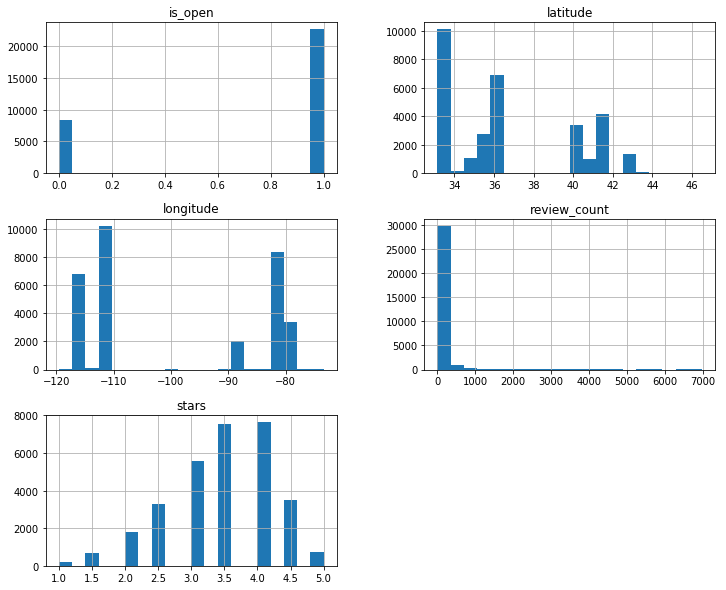

In [9]:
#Let's take a look at the distribution of numerial values

df_usa.hist(bins=20, figsize=(12,10))

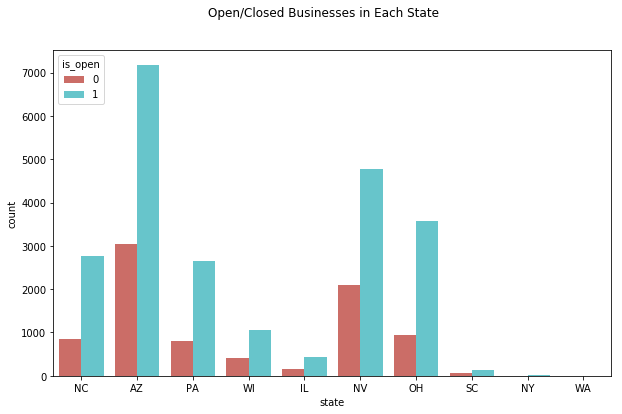

In [10]:
#Let's look at the data for the closed vs open businesses based on states

fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle("Open/Closed Businesses in Each State")
ax = sns.countplot(ax=ax,x="state", data=df_usa, hue="is_open",palette="hls")

In [11]:
#Let's take a closer look at the open/closed businesses in each state

df_state=df_usa.groupby(["state"],as_index=False)["is_open"].agg(['sum','count']).reset_index()
df_state.rename(columns={'sum':'opened','count':'total'},inplace=True)
df_state["%closed"]=round((df_state["total"]-df_state["opened"])/df_state["total"]*100,2)
df_state.sort_values("total",ascending=False)

,state,opened,total,%closed
0,AZ,7173,10219,29.81
3,NV,4780,6882,30.54
5,OH,3581,4513,20.65
2,NC,2769,3625,23.61
6,PA,2641,3435,23.11
9,WI,1069,1486,28.06
1,IL,436,598,27.09
7,SC,137,201,31.84
4,NY,10,11,9.09
8,WA,1,1,0.00


In [12]:
#As data from some of the states are not sufficient for meaningful analysis, we will remove the data from them -IL, SC, NY, WA

df_usa = df_usa[df_usa["state"].isin(["NC", "AZ", "PA", "NV", "OH", "WI"])]
len(df_usa)

30160

## Features Engineering
Up till now, we have limited our business data to confine to only restaurants in United States.  Next let's examine the feaures.

**Add new feature is_chain**

Whether a restaurant will close down may be impacted by whether it is a chain restaurant or not. We will check for chain restaurant from our dataset.

In [13]:
# We will define a restaurant to be part of a chain restaurant if the restaurant name is duplicated within the dataset.

df_dupl=df_usa[df_usa["name"].duplicated()].copy()
df_dupl.head(5)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
142,14175 W Indian School Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",XuLXX5B5W1P-iNpgXmqmjQ,"[Fast Food, Sandwiches, Restaurants]",Goodyear,"{'Monday': '8:00-22:00', 'Tuesday': '8:00-22:0...",1,33.484027,-112.363106,Subway,,85338,6,2.0,AZ
264,524 W Broadway Rd,{},EPkV2_H0TRcARa-2IFZ-2A,"[Pizza, Restaurants]",Tempe,{},1,33.408058,-111.946936,Papa John's Pizza,,85282,3,2.0,AZ
302,3501 S Rainbow,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",W-3Sy3fy85mQdd0ZNFKIiw,"[Sports Bars, Nightlife, Burgers, Bars, Americ...",Las Vegas,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,36.125270,-115.243588,Applebee's,Chinatown,89103,74,2.5,NV
400,714 S. Boulder Highway,"{'Alcohol': 'none', 'HasTV': False, 'Restauran...",L4PI4kh8plShtrcWt6aBTQ,"[Chicken Wings, Restaurants, Pizza]",Henderson,"{'Monday': '10:30-23:00', 'Tuesday': '10:30-23...",1,36.031596,-114.970039,Pizza Hut,,89015,12,2.0,NV
423,1020 E Pecos Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",rtcWSNA3HVehrnUDVphYoA,"[Fast Food, Sandwiches, Restaurants]",Chandler,{},1,33.293060,-111.823970,Subway,,85225,4,3.0,AZ


In [14]:
#We will add a column is_chain to indicate if the restaurant is a chain restaurant

chain_rest = df_dupl["name"].unique()
df_usa["is_chain"] = df_usa["name"].apply(lambda x: 1 if x in chain_rest else 0)
df_usa.reset_index(inplace=True,drop=True)
df_usa.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,is_chain
0,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC,0
1,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ,1
2,9616 E Independence Blvd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",SDMRxmcKPNt1AHPBKqO64Q,"[Burgers, Bars, Restaurants, Sports Bars, Nigh...",Matthews,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,35.135196,-80.714683,Applebee's,,28105,21,2.0,NC,1


**Add new feature num_nearby_rest**

The no. of other restaurants near the restaurants is likely to affect its business. We will add a new feature num_nearby_rest to indicate the no. of other restaurants within 1km of the restaurant. Subsequently we will group the num_nearby_rest figures into categories and store into num_nearby_rest_cate. 

We will ouput coordinates-related data to a csv file and worked on the computation in a separate script (refer to GetNearbyRestaurant.ipynb).

In [15]:
# We will output df_usa subset to a csv file for computation of nearby restaurants using another script.  

file_nearby_rest = "nearbyrestaurant.csv"
if os.path.isfile(os.path.join(path ,file_nearby_rest)) == False:
    df_output =df_usa[["state","business_id","name","postal_code","latitude","longitude"]].copy()

    with open('usa.csv', 'w', encoding="utf-8", newline= "") as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["state","business_id","name","postal_code","latitude","longitude"])
        for i in range(len(df_output)):
            writer.writerow(df_output.iloc[i])
else:
    print('No output to usa.csv')

No output to usa.csv


In [16]:
# Read the data from usa_nearby_restaurant.csv. This is the output csv from GetNearbyRestaurant.ipynb which contains no. of nearby restaurant within 1km of the business.

if os.path.isfile(os.path.join(path , file_nearby_rest)):
    df_nearby_rest = pd.read_csv(os.path.join(path,file_nearby_rest))
    df_nearby_rest=df_nearby_rest[["business_id","num_nearby_rest"]]
else:
    print('Not able to proceed as nearby restaurant data is not available')

In [17]:
#Merge data frm df_nearby_rest to df_usa to get no. of nearby restaurants

df_usa = pd.merge(df_usa, df_nearby_rest, on='business_id', how='left')
df_usa.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,is_chain,num_nearby_rest
0,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC,0,12
1,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ,1,90
2,9616 E Independence Blvd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",SDMRxmcKPNt1AHPBKqO64Q,"[Burgers, Bars, Restaurants, Sports Bars, Nigh...",Matthews,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,35.135196,-80.714683,Applebee's,,28105,21,2.0,NC,1,29


In [19]:
# Group num_nearby_rest figures into categories and output to num_nearby_rest_cate

def get_cate(num):
    if num == 0:
        cate = 0
    elif num > 0 and num <=5:
        cate = 1
    elif num > 5 and num <=10:
        cate = 2
    elif num > 10 and num <= 20:
        cate = 3
    elif num > 20 and num <= 30:
        cate = 4
    elif num > 30 and num <= 40:
        cate = 5
    elif num > 40 and num <= 50:
        cate = 6
    elif num > 50 and num <= 100:
        cate = 7
    elif num > 100 and num <= 200:
        cate = 8
    else:
        cate = 9
    return cate
        
df_usa["num_nearby_rest_cate"]=df_usa["num_nearby_rest"].apply(get_cate)

**Add new features 3mth_posrate and 3mth_negrate to df_review**

To get a sense of the kind of reviews the restaurants are getting for the past 3 mths, we will add 2 new features 3mth_posrate and 3mth_negrate which denote the positive and negative review rate for past 3 mths. 

Note: If a restaurant has been closed for many mths, we will not be able to extract any reviews for past 3 mths. As such, past 3 mths is based on 3mths before date of the last review of the restaurants. For example, if the last review received by the restaurant is 1 Apr 2017, then we will extract the positive and negative reviews from 1 Jan - 31 Mar 2017

In [20]:
# Let's look at data in review file

df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736897 entries, 0 to 4736896
Data columns (total 9 columns):
business_id    object
cool           int64
date           datetime64[ns]
funny          int64
review_id      object
stars          int64
text           object
useful         int64
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 325.3+ MB


In [21]:
# Filter the review dataframe and select only those where business id exists in df_usa

rest_list = df_usa["business_id"].tolist()
df_review = df_review[df_review["business_id"].isin(rest_list)]
len(df_review)

2334812

In [23]:
# Get max review date
df_review_dt=df_review.groupby("business_id",as_index=False)["date"].agg(['max']).reset_index()
df_review_dt.head(2)

,business_id,max
0,--9e1ONYQuAa-CB_Rrw7Tw,2017-07-23
1,--FBCX-N37CMYDfs790Bnw,2017-06-15


In [24]:
# We are only interested in the last 3 mths reviews based on the max review date

def get_date (dt):
    return dt + relativedelta(months=-3)

df_review_dt["base_date"] = df_review_dt["max"].apply(lambda x: get_date(x))

In [25]:
df_review_dt.head(5)

,business_id,max,base_date
0,--9e1ONYQuAa-CB_Rrw7Tw,2017-07-23,2017-04-23
1,--FBCX-N37CMYDfs790Bnw,2017-06-15,2017-03-15
2,--GM_ORV2cYS-h38DSaCLw,2017-01-16,2016-10-16
3,--I7YYLada0tSLkORTHb5Q,2017-07-26,2017-04-26
4,--KCl2FvVQpvjzmZSPyviA,2017-05-31,2017-02-28


In [26]:
# Merge df_review with review group data

df_review = pd.merge(df_review, df_review_dt, on='business_id', how='left')
df_review.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,max,base_date
0,jQsNFOzDpxPmOurSWCg1vQ,0,2017-06-03,0,ByRzJ8rF2KJWLr-cUNU6EA,1,"This place is horrible, we were so excited to ...",0,kzyLOqiJvyw_FWFTw2rjiQ,2017-07-08,2017-04-08
1,jQsNFOzDpxPmOurSWCg1vQ,0,2015-03-26,0,i5UwUPlQFPLcE8p2gPFwBw,4,"For being fairly ""fast"" food.. Pei Wei (pronou...",1,WZXp9-V2dqRRJqhGgRqueA,2017-07-08,2017-04-08
2,jQsNFOzDpxPmOurSWCg1vQ,1,2012-12-30,1,EyQyvTTg2jX4or9bB8PC9g,5,"I decided to try it out, I'm celiac and theref...",2,XylT12exfdLiI_3uDLVIpw,2017-07-08,2017-04-08


In [27]:
# check for missing values after merge

df_review.isnull().any()

business_id    False
cool           False
date           False
funny          False
review_id      False
stars          False
text           False
useful         False
user_id        False
max            False
base_date      False
dtype: bool

In [28]:
#Filter the dataframe to get only past 3 mths reviews recs

df_review = df_review[df_review["date"] > df_review["base_date"]].copy()

In [29]:
df_review=df_review[["business_id", "stars", "max"]]

In [30]:
#Get the positive and negative reviews count.  Positive reviews are those with 5 stars. Negative reviews are those 1 star.

df_review["3mth_pos"] = df_review["stars"].apply(lambda x: 1 if x >= 5 else 0)
df_review["3mth_neg"] = df_review["stars"].apply(lambda x: 1 if x <= 1 else 0)

In [31]:
df_review.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191736 entries, 0 to 2334533
Data columns (total 5 columns):
business_id    191736 non-null object
stars          191736 non-null int64
max            191736 non-null datetime64[ns]
3mth_pos       191736 non-null int64
3mth_neg       191736 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 21.8 MB


In [32]:
df_review.head(3)

,business_id,stars,max,3mth_pos,3mth_neg
0,jQsNFOzDpxPmOurSWCg1vQ,1,2017-07-08,0,1
15,jQsNFOzDpxPmOurSWCg1vQ,1,2017-07-08,0,1
57,jQsNFOzDpxPmOurSWCg1vQ,3,2017-07-08,0,0


In [33]:
# Get the positive and negative review rate for each business
# Positive rate = positive review count for past 3 mths/review count for past 3 mths.  Conversely for negative review rate

df_grp = df_review.groupby(["business_id","max"],as_index=False).agg({"3mth_pos": "sum", "3mth_neg": "sum","stars":"count"})
df_grp["3mth_posrate"] = np.round(df_grp["3mth_pos"]/df_grp["stars"],2)
df_grp["3mth_negrate"] = np.round(df_grp["3mth_neg"]/df_grp["stars"],2)

In [34]:
df_grp.head(5)

,business_id,max,3mth_pos,3mth_neg,stars,3mth_posrate,3mth_negrate
0,--9e1ONYQuAa-CB_Rrw7Tw,2017-07-23,22,1,40,0.55,0.02
1,--FBCX-N37CMYDfs790Bnw,2017-06-15,3,3,6,0.50,0.50
2,--GM_ORV2cYS-h38DSaCLw,2017-01-16,2,0,3,0.67,0.00
3,--I7YYLada0tSLkORTHb5Q,2017-07-26,4,1,6,0.67,0.17
4,--KCl2FvVQpvjzmZSPyviA,2017-05-31,0,0,1,0.00,0.00


In [35]:
#Drop obsolete columns

df_grp.drop(["3mth_pos","3mth_neg","stars"],axis=1, inplace=True)

**Merge df_usa with review dataframe df_grp**

In [36]:
df = pd.merge(df_usa, df_grp, on='business_id', how='left')

In [37]:
df_bkup = df.copy() #keep backup copy
df.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,postal_code,review_count,stars,state,is_chain,num_nearby_rest,num_nearby_rest_cate,max,3mth_posrate,3mth_negrate
0,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,...,28215,4,4.5,NC,0,12,3,2016-08-14,0.5,0.0
1,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,...,85016,10,4.5,AZ,1,90,7,2015-07-27,1.0,0.0
2,9616 E Independence Blvd,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",SDMRxmcKPNt1AHPBKqO64Q,"[Burgers, Bars, Restaurants, Sports Bars, Nigh...",Matthews,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,35.135196,-80.714683,Applebee's,...,28105,21,2.0,NC,1,29,4,2017-03-22,0.0,0.5


In [38]:
df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state', 'is_chain',
       'num_nearby_rest', 'num_nearby_rest_cate', 'max', '3mth_posrate',
       '3mth_negrate'],
      dtype='object')

In [39]:
df.corr()

,is_open,latitude,longitude,review_count,stars,is_chain,num_nearby_rest,num_nearby_rest_cate,3mth_posrate,3mth_negrate
is_open,1.000000,0.059985,0.081852,0.130208,0.007067,0.191351,-0.071111,-0.104650,0.098164,0.010419
latitude,0.059985,1.000000,0.707055,-0.107340,0.026530,-0.086445,0.005361,-0.078363,-0.027245,-0.061140
longitude,0.081852,0.707055,1.000000,-0.178716,0.009062,-0.063046,-0.097901,-0.181091,-0.042629,-0.058722
review_count,0.130208,-0.107340,-0.178716,1.000000,0.159441,-0.062868,0.246461,0.217566,0.100721,-0.108433
stars,0.007067,0.026530,0.009062,0.159441,1.000000,-0.338002,0.031596,0.033438,0.533172,-0.552547
is_chain,0.191351,-0.086445,-0.063046,-0.062868,-0.338002,1.000000,-0.097811,-0.033285,-0.166529,0.209944
num_nearby_rest,-0.071111,0.005361,-0.097901,0.246461,0.031596,-0.097811,1.000000,0.781876,-0.007857,-0.055167
num_nearby_rest_cate,-0.104650,-0.078363,-0.181091,0.217566,0.033438,-0.033285,0.781876,1.000000,-0.002173,-0.052041
3mth_posrate,0.098164,-0.027245,-0.042629,0.100721,0.533172,-0.166529,-0.007857,-0.002173,1.000000,-0.469054
3mth_negrate,0.010419,-0.061140,-0.058722,-0.108433,-0.552547,0.209944,-0.055167,-0.052041,-0.469054,1.000000


In [40]:
df.describe()

,is_open,latitude,longitude,review_count,stars,is_chain,num_nearby_rest,num_nearby_rest_cate,3mth_posrate,3mth_negrate
count,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000
mean,0.729874,36.750324,-99.672457,77.408654,3.430272,0.422845,57.650729,4.694861,0.348362,0.235099
std,0.444032,3.281873,15.719742,180.808702,0.797023,0.494019,79.250419,2.428928,0.349960,0.330944
min,0.000000,33.137277,-119.551325,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.581518,-112.278488,9.000000,3.000000,0.000000,13.000000,3.000000,0.000000,0.000000
50%,1.000000,36.057697,-111.864114,26.000000,3.500000,0.000000,29.000000,4.000000,0.330000,0.030000
75%,1.000000,40.443069,-81.377158,77.000000,4.000000,1.000000,60.000000,7.000000,0.580000,0.380000
max,1.000000,46.504003,-75.525922,6979.000000,5.000000,1.000000,441.000000,9.000000,1.000000,1.000000


In [41]:
# Select the features to be used for model training
df_final = df[["is_open","review_count","state", "is_chain","num_nearby_rest_cate", "3mth_posrate", "3mth_negrate"]]

In [42]:
#Convert categorial columns to dummy variablesf
df_final = pd.get_dummies(df_final, columns=["state"])

In [44]:
df_final.columns

Index(['is_open', 'review_count', 'is_chain', 'num_nearby_rest_cate',
       '3mth_posrate', '3mth_negrate', 'state_AZ', 'state_NC', 'state_NV',
       'state_OH', 'state_PA', 'state_WI'],
      dtype='object')

## Modelling and model evaluation

In [45]:
target = df_final["is_open"]
data = df_final.drop("is_open", axis=1)

In [50]:
# Split train and test set

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=8)
for train_index, test_index in split.split(data, target):
    strat_train_set = df_final.loc[train_index]
    strat_test_set = df_final.loc[test_index]

In [51]:
strat_train_set.columns

Index(['is_open', 'review_count', 'is_chain', 'num_nearby_rest_cate',
       '3mth_posrate', '3mth_negrate', 'state_AZ', 'state_NC', 'state_NV',
       'state_OH', 'state_PA', 'state_WI'],
      dtype='object')

In [52]:
#X = strat_train_set[['stars','is_chain', 'num_nearby_rest', '3mth_posrate', '3mth_negrate', 'avg_review_per_wk', 'state_AZ', 'state_IL', 'state_NC','state_NV', 'state_OH', 'state_PA', 'state_SC', 'state_WI']]
X = strat_train_set.drop(columns="is_open",axis=1)
y = strat_train_set["is_open"]

**Feature scaling**

In [54]:
#Apply feature scaling to the train set

from sklearn.preprocessing import StandardScaler, RobustScaler
#scale = StandardScaler()
scale = RobustScaler()
train_x_scaled = scale.fit(X)
train_x = scale.transform(X)

In [99]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score

In [109]:
k_fold = KFold(n_splits=10,random_state = 8, shuffle=True)

LG = LogisticRegression(class_weight='balanced', random_state = 8)
RF = RandomForestClassifier(class_weight='balanced', random_state = 8)
GBC = GradientBoostingClassifier(random_state = 8)
XG = XGBClassifier(scale_pos_weight = 0.37, seed=8)
BBC = BalancedBaggingClassifier(base_estimator=XGBClassifier(),ratio='auto',replacement=False,random_state=8)

clf_list = {"clf": [LG, RF, XG, GBC, BBC], "desc": ["LogisticRegression","RandomForest", "XGBoost" ,"GradientBoosting","BalBagging"]}


 LogisticRegression
             precision    recall  f1-score   support

          0       0.44      0.70      0.54      6518
          1       0.86      0.67      0.76     17610

avg / total       0.75      0.68      0.70     24128

Average precision score: 0.873

 RandomForest
             precision    recall  f1-score   support

          0       0.48      0.48      0.48      6518
          1       0.81      0.81      0.81     17610

avg / total       0.72      0.72      0.72     24128

Average precision score: 0.841

 XGBoost
             precision    recall  f1-score   support

          0       0.49      0.71      0.58      6518
          1       0.87      0.73      0.79     17610

avg / total       0.77      0.72      0.74     24128

Average precision score: 0.899

 GradientBoosting
             precision    recall  f1-score   support

          0       0.63      0.38      0.47      6518
          1       0.80      0.92      0.86     17610

avg / total       0.75      0.77    

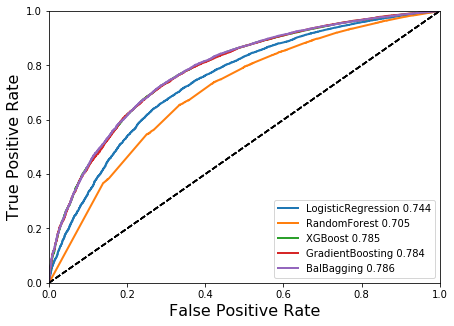

In [110]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

def run_cvp(X, y, kfold, clf_class):
    return cross_val_predict(clf_class, X, y, cv=kfold )

def run_cvp_prob(X, y, kfold, clf_class):
    return cross_val_predict(clf_class, X, y, cv=kfold, method="predict_proba")

def run_cvp_decision(X, y, kfold, clf_class):
    return cross_val_predict(clf_class, X, y, cv=kfold, method="decision_function" )
  
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

color=['y','b','r','g','b']    

for i in range(len(clf_list["clf"])):
    y_train_pred = run_cvp(train_x,y,k_fold, clf_list["clf"][i])

    print("\n", clf_list["desc"][i])    
    print(classification_report(y, y_train_pred))

    if (clf_list["desc"][i] != "RandomForest") & (clf_list["desc"][i] != "XGBoost") & (clf_list["desc"][i] != "BalBagging"):
        y_score = run_cvp_decision(train_x,y,k_fold, clf_list["clf"][i])
    else:
        y_score = run_cvp_prob(train_x,y,k_fold, clf_list["clf"][i])[:, 1]

    aps = round(average_precision_score(y, y_score),3)
    print("Average precision score:", aps)

    
    fpr, tpr, thresholds = roc_curve(y, y_score)
    auc = round(roc_auc_score(y,y_score),3)
   
    if i ==0:
        plt.figure(0).clf()
        plt.figure(figsize=(7, 5))
        
    plot_roc_curve(fpr, tpr, clf_list["desc"][i]+" " + str(auc))
    
plt.legend(loc=0)
plt.show()

    

## Hyperparameters tuning

In [111]:
from sklearn.model_selection import GridSearchCV

def run_grid(X, y, kfold, clf_class, param):
    grid_search = GridSearchCV(estimator = clf_class, param_grid = param, scoring = 'average_precision',cv = kfold, )
    grid_search = grid_search.fit(X,y)
    return [grid_search.best_score_, grid_search.best_params_,grid_search.best_estimator_]


GBC_param = [{'loss': ['deviance'], 'learning_rate' : [0.17,0.18,0.19], "n_estimators": [120,130,140]},
             {'loss': ['exponential'], 'learning_rate' : [0.17,0.18,0.19], "n_estimators": [120,130,140]}]

XG_param = [{'learning_rate': [0.06,0.07,0.08], 'n_estimators':[210,220,230], 'gamma':[0.8,0.9,1,1.1]}]

BBC_param = [{'n_estimators':[190,200,210,220]}]

grid_result=[]
grid_result.append(run_grid(train_x, y, k_fold, GBC, GBC_param))
grid_result.append(run_grid(train_x, y, k_fold, XG, XG_param))
grid_result.append(run_grid(train_x, y, k_fold, BBC, BBC_param))

grid_result

[[0.90054203664817067,
  {'learning_rate': 0.18, 'loss': 'exponential', 'n_estimators': 130},
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.18, loss='exponential', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=130,
                presort='auto', random_state=8, subsample=1.0, verbose=0,
                warm_start=False)],
 [0.90016350153905422,
  {'gamma': 0.8, 'learning_rate': 0.07, 'n_estimators': 210},
  XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
         gamma=0.8, learning_rate=0.07, max_delta_step=0, max_depth=3,
         min_child_weight=1, missing=None, n_estimators=210, nthread=-1,
         objective='binary:logistic', reg_alpha=0, reg_lambda=1,
         scale_pos_weight=0.37, seed=8, silent=Tr

In [112]:
# Select best estimator

best_score = 0
for i in range(len(grid_result)):
    if grid_result[i][0] > best_score:
        best_score = grid_result[i][0]
        best_estimator = grid_result[i][2]
print(best_score, best_estimator)

0.900542036648 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.18, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=130,
              presort='auto', random_state=8, subsample=1.0, verbose=0,
              warm_start=False)


## Prediction
The best estimator based on GridSearch is the Gradient Boosting model.  We will use this model to make prediction on our test data.

In [113]:
final_model = best_estimator

# Test dataset
Xt = strat_test_set[X.columns]
yt = strat_test_set["is_open"]

test_x = scale.transform(Xt)

final_prediction = final_model.predict(test_x)

In [114]:
# Evaluate test data results

print(classification_report(yt, final_prediction))

             precision    recall  f1-score   support

          0       0.63      0.40      0.49      1629
          1       0.81      0.91      0.86      4403

avg / total       0.76      0.77      0.76      6032



Confusion matrix, without normalization
[[ 657  972]
 [ 387 4016]]
Normalized confusion matrix
[[ 0.4   0.6 ]
 [ 0.09  0.91]]


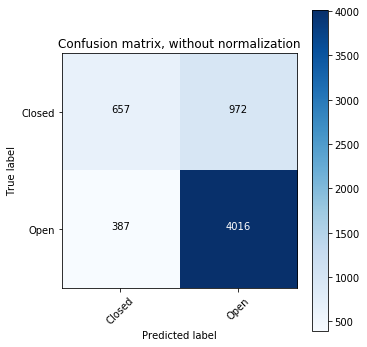

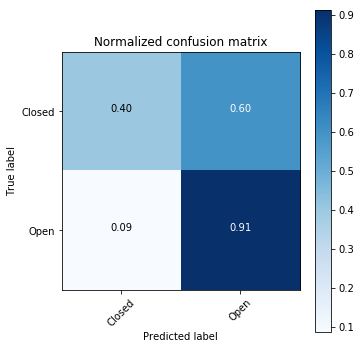

In [115]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(yt,final_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
classNames = ['Closed','Open']
plot_confusion_matrix(cnf_matrix, classes=classNames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classNames, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [120]:
precision = precision_score(yt,final_prediction)
recall = recall_score(yt, final_prediction)
specificity = cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("Precsion:", precision)
print("Recall:", recall)
print("Specificity", specificity)

Precsion: 0.805132317562
Recall: 0.912105382694
Specificity 0.403314917127


**For our problem, we would be looking at restaurants which have a high chance of survival to make our investment/financial decisions.  Hence, a high recall rate will be preferable. The Gradient Boosting Classifier model has ouput a model with high recall rate and the precision rate is comparatively good as well.**

**The dataset has an imbalanced distribution of the target values. In training our models, we use weight to counter the imbalance efffect (except for logistic regression). We could try to use sampling methods to handle the imbalanced dataset as well. To improve the model, we could also try to gather more data to add more useful features to include in our model training.**